# OBJECTIVE #
1.<b> APPLYING SVM  WITH BOW VECTORIZATION

2. FINDING THE BEST HYPERPARAMETER USING GRIDSEARCHCV WITH TRAIN DATA AND CROSS-VALIDATION       DATA BY PLOTTING THE RESLUTS OF CROSS VALIDATION DATA UISNG HEATMAP
  
3. PLOTTING OF ROC CURVE TO CHECK FOR THE AUC_SCORE 
  
4. USING THE APROPRIATE VALUE OF HYPERPARAMETER ,TESTING 
    ACCURACY ON TEST DATA USING AUC_SCORE
  
5. PLOTTING THE CONFUSION MATRIX TO GET THE PRECISOIN ,RECALL
    VALUE WITH HELP OF HEATMAP
  
6. PRINTING THE TOP 30 MOST IMPORTANT FEATURES

In [2]:
from sklearn.model_selection import train_test_split          #importing the necessary libraries
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import *
from sklearn import naive_bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd
from sklearn import *
import warnings
warnings.filterwarnings("ignore")

In [3]:
final_processed_data=pd.read_csv("C:/Users/Mayank/Desktop/final_new_data.csv")#loading the preprocessed data  with 100k points into dataframe 

In [4]:
# getting the counts of 0 and 1 in "SCORE" column to know whether it is unbalanced data or not
count_of_1=0
count_of_0=0
for i in final_processed_data['Score']:
   if i==1:
    count_of_1+=1
   else:
    count_of_0+=1
print(count_of_1)
print(count_of_0)
#it is an imbalanced dataset

88521
11479


In [5]:
#spliiting the data into train and test data
x_train,x_test,y_train,y_test=model_selection.train_test_split(final_processed_data['CleanedText'].values,final_processed_data['Score'].values,test_size=0.2,shuffle=False)

In [6]:
vectorizer=CountVectorizer(min_df=5)#building the vertorizer with word counts equal and more then 2
train_bow=vectorizer.fit_transform(x_train)#fitting the model on training data
print(train_bow.shape)

(80000, 10917)


In [7]:
from sklearn.preprocessing import StandardScaler #standarizing the training  data  
x_train_data=StandardScaler( with_mean=False).fit_transform(train_bow)
print(x_train_data.shape)

(80000, 10917)


In [8]:
test_bow=vectorizer.transform(x_test)#fitting the bow model on test data
print("shape of x_test after tfidf vectorization ",test_bow.shape)
x_test_data=StandardScaler( with_mean=False).fit_transform(test_bow)#standarizing the test data
print("shape of x_test after standardization ",x_test_data.shape)

shape of x_test after tfidf vectorization  (20000, 10917)
shape of x_test after standardization  (20000, 10917)


In [9]:
#using time series split method for cross-validation score
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10) 
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
data=[10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]#range of hyperparameter


sgd=SGDClassifier(loss='log',class_weight={1:0.5,0:0.5},n_jobs=-1)
tuned_para=[{'alpha':data,'penalty':['l1','l2']}] 


In [10]:
#applying the model of support vector machine and using gridsearchcv to find the best hyper parameter
%time
from sklearn.model_selection import GridSearchCV
model = GridSearchCV(sgd, tuned_para, scoring = 'roc_auc', cv=tscv,n_jobs=-1)#building the gridsearchcv model
model.fit(x_train_data, y_train)#fiitting the training data

print('best estimators for the model is',model.best_estimator_)#printing the best_estimator
print('Auc_score for test data is',model.score(x_test_data, y_test))


Wall time: 0 ns
best estimators for the model is SGDClassifier(alpha=0.01, average=False, class_weight={1: 0.5, 0: 0.5},
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=-1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
Auc_score for test data is 0.869072793835


In [16]:
results=pd.DataFrame(model.cv_results_)# getting varoius cv_scores and train_scores various values of alpha given as parameter and storing it in a dataframe
results.head()#printing the dataframe
results['mean_train_score']=results['mean_train_score'].round(2)

# PLOTTING THE HEATMAP WITH  HYPERPARAMETERS FOR AUC_SCORE 

In [20]:
train_score_heatmap=results.pivot(	'param_alpha'	,'param_penalty','mean_train_score'	)

In [21]:
train_score_heatmap

param_penalty,l1,l2
param_alpha,,
0.0001,0.96,0.99
0.0010,0.89,0.99
0.0100,0.71,0.99
0.1000,0.51,0.96
1.0000,0.50,0.81
10.0000,0.50,0.63
100.0000,0.50,0.58
1000.0000,0.50,0.58
10000.0000,0.50,0.58


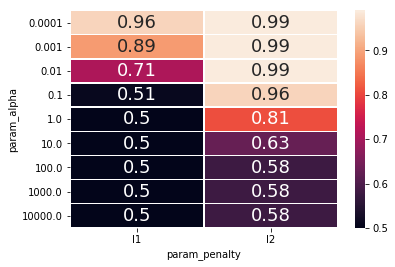

In [22]:
import seaborn as sns
sns.heatmap(train_score_heatmap,annot=True,annot_kws={"size": 18}, fmt='g',linewidths=.5)
import matplotlib.pyplot as plt
plt.show()

# FROM HEATMAP THE BEST HYPERPARAMETER VALUES ARE FOUND TO BE PENALTY='L2' AND 'PARAM_ALPHA'=0.01

# BUILDING MODEL FOR SGD WITH CALIBRATED CLASSIFIER CV WITH DIFFERENT VARIATIONS

In [23]:
sgd=SGDClassifier(loss='log',class_weight={1:0.5,0:0.5},n_jobs=-1,alpha=0.01,penalty='l2')
sgd.fit(x_train_data,y_train)

SGDClassifier(alpha=0.01, average=False, class_weight={1: 0.5, 0: 0.5},
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=-1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [24]:
from sklearn.metrics import brier_score_loss
prob_pos_clf = sgd.predict_proba(x_test_data)[:, 1]

# Gaussian Naive-Bayes with isotonic calibration
from sklearn.calibration import   CalibratedClassifierCV
clf_isotonic = CalibratedClassifierCV(sgd, cv=5, method='isotonic')
clf_isotonic.fit(x_train_data, y_train)
prob_pos_isotonic = clf_isotonic.predict_proba(x_test_data)[:, 1]

# Gaussian Naive-Bayes with sigmoid calibration
clf_sigmoid = CalibratedClassifierCV(sgd, cv=5, method='sigmoid')
clf_sigmoid.fit(x_train_data, y_train)
prob_pos_sigmoid = clf_sigmoid.predict_proba(x_test_data)[:, 1]

print("Brier scores: (the smaller the better)")

clf_score = brier_score_loss(y_test, prob_pos_clf)
print("No calibration: %1.3f" % clf_score)


clf_isotonic_score = brier_score_loss(y_test, prob_pos_isotonic)
print("With isotonic calibration: %1.3f" % clf_isotonic_score)

clf_sigmoid_score = brier_score_loss(y_test, prob_pos_sigmoid)
print("With sigmoid calibration: %1.3f" % clf_sigmoid_score)

Brier scores: (the smaller the better)
No calibration: 0.069
With isotonic calibration: 0.069
With sigmoid calibration: 0.071


# ISOTONIC CALIBRATION IS HAVING BEST VALUE  FOR CALIBRATED CLASSIFIER CV

 # PLOTTING THE ROC CURVE FOR  TRAIN_DATA

In [25]:
sgd=SGDClassifier(loss='log',class_weight={1:0.5,0:0.5},n_jobs=-1,alpha=0.01,penalty='l2')
from sklearn.calibration import   CalibratedClassifierCV
clf_isotonic = CalibratedClassifierCV(sgd, cv=5, method='isotonic')
clf_isotonic.fit(x_train_data, y_train)
prob_pos_isotonic = clf_isotonic.predict_proba(x_train_data)[:, 1]

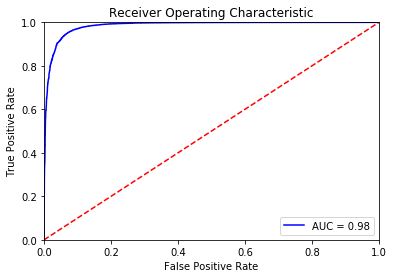

In [26]:
y_pred_train=model.predict_proba(x_train_data)
fpr, tpr, threshold = metrics.roc_curve(y_train, prob_pos_isotonic)
roc_auc = metrics.auc(fpr, tpr)

# 
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'best')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

 # PLOTTING THE ROC CURVE FOR  TEST DATA

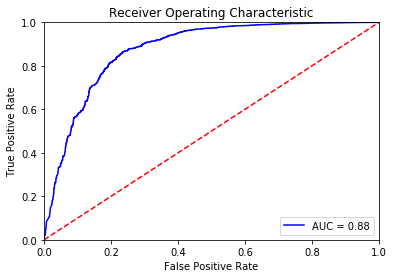

In [28]:
prob_pos_isotonic = clf_isotonic.predict_proba(x_test_data)[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_test, prob_pos_isotonic)
roc_auc = metrics.auc(fpr, tpr)

# 
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'best')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [29]:
print("FROM ABOVE PLOT,AUC_SCORE IS FOUND AS ",roc_auc)

FROM ABOVE PLOT,AUC_SCORE IS FOUND AS  0.875555404483


 # REPRESENTING TOP IMPORTANT FEATURES USING WORDCLOUD LIBRARY

In [28]:
z=sgd.coef_[0]#getting the wieght of the vector 
print(z)#printing the wieght of the vector

[ 0.00154205  0.00072253 -0.00089986 ... -0.00020845  0.00526312
  0.00421044]


In [29]:
a=z.argsort()
print('shape of wieght vector is:',a.shape)
top_30_positive=np.take(vectorizer.get_feature_names(),a[10887:])
top_30_negative=np.take(vectorizer.get_feature_names(),a[:30])

shape of wieght vector is: (10917,)


In [30]:
print(top_30_positive)#TOP 30 POSITIVE WORDS
print(top_30_negative)#TOP 30 NEGATIVE WORDS

['flavor' 'addict' 'store' 'happi' 'ever' 'yummi' 'right' 'keep' 'make'
 'fast' 'enjoy' 'price' 'quick' 'high' 'use' 'thank' 'snack' 'tasti'
 'easi' 'find' 'wonder' 'nice' 'perfect' 'excel' 'favorit' 'delici' 'best'
 'good' 'love' 'great']
['disappoint' 'worst' 'terribl' 'aw' 'unfortun' 'threw' 'mayb' 'horribl'
 'bad' 'return' 'money' 'wors' 'thought' 'wast' 'bland' 'stale' 'refund'
 'hope' 'sorri' 'vomit' 'unpleas' 'tasteless' 'suppos' 'poor' 'didnt'
 'lack' 'disgust' 'gross' 'guess' 'descript']


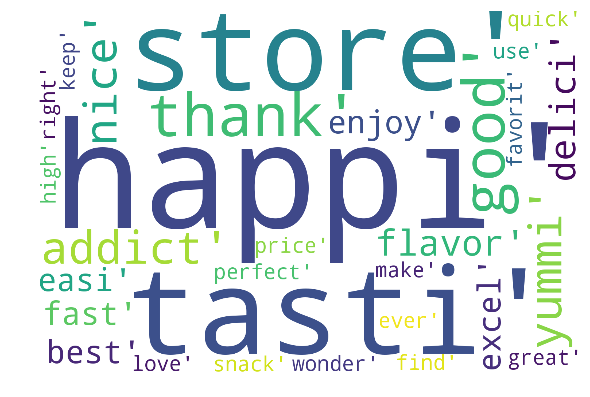

In [34]:
from wordcloud import WordCloud #here we are printing the top features using wordcloud library
import matplotlib.pyplot as plt
wordcloud = WordCloud(width = 1500, height = 1000, 
                background_color ='white', 
                 
                min_font_size = 10).generate(str(top_30_positive)) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

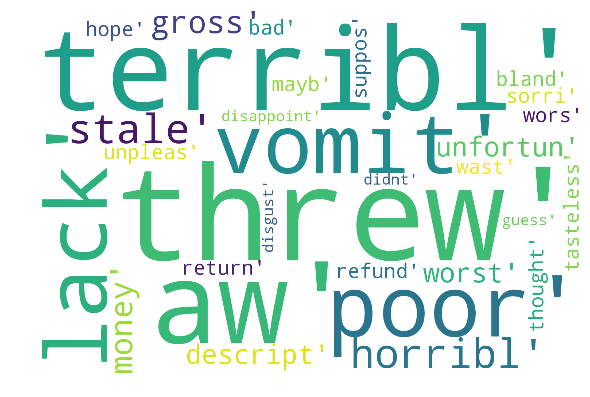

In [35]:
from wordcloud import WordCloud #here we are printing the top features using wordcloud library
import matplotlib.pyplot as plt
wordcloud = WordCloud(width = 1500, height = 1000, 
                background_color ='white',
                min_font_size = 10).generate(str(top_30_negative)) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

 # USING BEST HYPERPARAMETER VALUE ON TEST DATA AND PLOTTING THE CONFUSION MATRIX WITH HEATMAP

Accuracy on test set: 91.315%
Precision on test set: 0.923
Recall on test set: 0.983
F1-Score on test set: 0.952
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



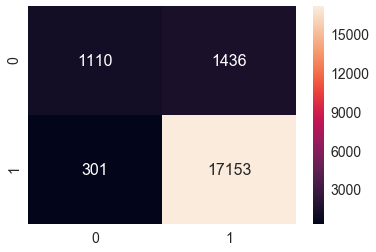

In [30]:
#Testing Accuracy on Test data  
import seaborn as sns #importing seaborn as sns
from sklearn.metrics import *#importing varoius metrics from sklearn
y_pred=clf_isotonic.predict(x_test_data)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))#printing accuracy
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))#printing precision score
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred))) #printing recall
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred))) 
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n") 
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2)) #generating the heatmap for confusion matrix
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
import matplotlib.pyplot as plt
plt.show()

# RBF KERNEL WITH BOW VECTORIZATION

# OBJECTIVE #
1.<b> APPLYING SVM WITH RBF KERNEL  WITH BOW VECTORIZATION

2.FINDING THE BEST HYPERPARAMETER USING GRIDSEARCHCV WITH
 TRAIN DATA AND CROSS-VALIDATION DATA BY PLOTTING THE
RESLUTS OF  CROSS VALIDATION DATA UISNG HEATMAP
  
 3.PLOTTING OF ROC CURVE TO CHECK FOR THE AUC_SCORE 
  
4.USING THE APROPRIATE VALUE OF HYPERPARAMETER ,TESTING
ACCURACY ON TEST DATA USING F1-SCORE
  
5.PLOTTING THE CONFUSION MATRIX TO GET THE PRECISOIN ,RECALL
VALUE WITH HELP OF HEATMAP
  

##  RBF KERNEL IS COMPUTATIONALLY EXPENSIVE SO USING FIRST 30K POINTS ONLY

In [32]:
final_data=pd.read_csv("C:/Users/Mayank/Desktop/final_new_data.csv")
#loading the preprocessed data  with 100k points into dataframe 
final_data.head()


,Score,CleanedText
0,1,witti littl book make son laugh loud recit car...
1,1,rememb see show air televis year ago child sis...
2,1,beetlejuic well written movi everyth excel act...
3,1,twist rumplestiskin captur film star michael k...
4,1,twist rumplestiskin captur film star michael k...


In [33]:
#spliiting the data into train and test data
x_train,x_test,y_train,y_test=model_selection.train_test_split(final_data['CleanedText'].values,final_data['Score'].values,test_size=0.30,shuffle=False)

In [34]:
vectorizer=CountVectorizer(min_df=10,max_features=1000)#building the vertorizer with word counts equal and more then 2
train_bow=vectorizer.fit_transform(x_train)#fitting the model on training data
print(train_bow.shape)

(70000, 1000)


In [35]:
from sklearn.preprocessing import StandardScaler #standarizing the training  data  
x_train_data=StandardScaler( with_mean=False).fit_transform(train_bow)
print(x_train_data.shape)

(70000, 1000)


In [36]:
test_bow=vectorizer.transform(x_test)#fitting the bow model on test data
print("shape of x_test after tfidf vectorization ",test_bow.shape)
x_test_data=StandardScaler( with_mean=False).fit_transform(test_bow)#standarizing the test data
print("shape of x_test after standardization ",x_test_data.shape)

shape of x_test after tfidf vectorization  (30000, 1000)
shape of x_test after standardization  (30000, 1000)


In [38]:
#using time series split method for cross-validation score
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=2) 
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
c_values=[10**-2,10**-1,1,10**1,10**2]#range of hyperparameter
gamma_values=[10**-2,10**-1,1,10**1,10**2]#range of hyperparameter
svc=SVC(class_weight='balanced',probability=True)
tuned_para=[{'C':c_values,'gamma':gamma_values}] 

In [8]:
#applying the model of support vector machine and using gridsearchcv to find the best hyper parameter
%time
from sklearn.model_selection import GridSearchCV
model = GridSearchCV(svc, tuned_para, scoring = 'f1', cv=tscv,n_jobs=-1)#building the gridsearchcv model




CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.63 µs


In [9]:
%%time
model.fit(x_train_data, y_train)#fiitting the training data

CPU times: user 32min 10s, sys: 1.34 s, total: 32min 12s
Wall time: 2h 4min 26s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=2),
       error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'gamma': [0.01, 0.1, 1, 10, 100], 'C': [0.01, 0.1, 1, 10, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [10]:
model.best_estimator_

SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

# BUILDING THE HEATMAP FOR CV_ERROR SCORE FOR HYPERPARAMETERS

In [11]:
results=pd.DataFrame(model.cv_results_)# getting varoius cv_scores and train_scores various values of alpha given as parameter and storing it in a dataframe
#printing the dataframe

In [12]:
results['mean_test_score']=results['mean_test_score']*100 #MULTIPLYING TEST_SCORE BY 100
results['mean_test_score']=100-results['mean_test_score']# SUBSTRACTING FROM 100
results['mean_cv_error']=results['mean_test_score'].round(decimals=2)# ROUNDING OFF TO 2 DECIMAL PLACES 
results.head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,param_gamma,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,std_fit_time,std_score_time,std_test_score,std_train_score,mean_cv_error
0,547.670137,39.501630,19.791369,0.79836,0.01,0.01,"{'gamma': 0.01, 'C': 0.01}",20,0.800754,0.797561,0.803419,0.799159,381.176123,11.734715,0.001332,0.000799,19.79
1,605.559178,39.958722,19.791369,0.79836,0.01,0.1,"{'gamma': 0.1, 'C': 0.01}",20,0.800754,0.797561,0.803419,0.799159,438.713114,14.598317,0.001332,0.000799,19.79
2,611.808663,40.843229,19.791369,0.79836,0.01,1,"{'gamma': 1, 'C': 0.01}",20,0.800754,0.797561,0.803419,0.799159,429.069206,9.907730,0.001332,0.000799,19.79
3,610.442541,39.849270,19.791369,0.79836,0.01,10,"{'gamma': 10, 'C': 0.01}",20,0.800754,0.797561,0.803419,0.799159,432.851733,9.413997,0.001332,0.000799,19.79
4,560.933864,37.374223,19.791369,0.79836,0.01,100,"{'gamma': 100, 'C': 0.01}",20,0.800754,0.797561,0.803419,0.799159,407.759922,10.712822,0.001332,0.000799,19.79


In [13]:
test_score_heatmap=results.pivot(	'param_C'	,'param_gamma','mean_cv_error'	)

In [14]:
test_score_heatmap

param_gamma,0.01,0.1,1.0,10.0,100.0
param_C,,,,,
0.01,19.79,19.79,19.79,19.79,19.79
0.10,57.86,17.84,17.84,17.84,17.84
1.00,14.37,15.09,15.10,15.10,15.10
10.00,14.41,15.09,15.10,15.10,15.10
100.00,14.41,15.09,15.10,15.10,15.10


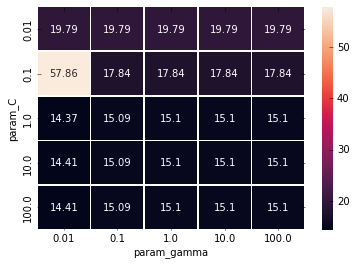

In [16]:
import seaborn as sns
sns.heatmap(test_score_heatmap,annot=True,annot_kws={"size": 10}, fmt='g',linewidths=.5)
import matplotlib.pyplot as plt
plt.show()

# FROM HERE BEST HPYERPARAMETERS ARE GAMMA =.01   AND  C=1

In [39]:
svc=SVC(class_weight='balanced',probability=True,C=1,gamma=.01)

# PLOTTING THE ROC CURVE FOR TRAIN DATA GETTING THE AUC_SCORE

In [ ]:
svc.fit(x_train_data,y_train)
probs = svc.predict_proba(x_train_data)#predicting the model 
y_pred= probs[:,1]


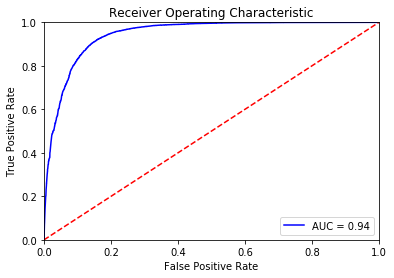

In [16]:
fpr, tpr, threshold = metrics.roc_curve(y_train, y_pred)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'best')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# PLOTTING THE ROC CURVE FOR TEST DATA GETTING THE AUC_SCORE

In [19]:
svc.fit(x_train_data,y_train)
probs = svc.predict_proba(x_test_data)#predicting the model 
y_pred=y_pred = probs[:,1]

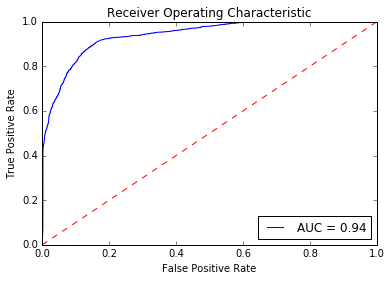

In [20]:

fpr, tpr, threshold = metrics.roc_curve(y_test,y_pred)
roc_auc = metrics.auc(fpr, tpr)
 
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'best')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# USING BEST HYPERPARAMETER VALUE ON TEST DATA AND PLOTTING THE CONFUSION MATRIX WITH HEATMAP

In [21]:
#Testing Accuracy on Test data  
import seaborn as sns #importing seaborn as sns
from sklearn.metrics import *#importing varoius metrics from sklearn
y_pred=svc.predict(x_test_data)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))#printing accuracy
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))#printing precision score
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred))) #printing recall
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred))) 
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n") 
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2)) #generating the heatmap for confusion matrix
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

Accuracy on test set: 80.378%
Precision on test set: 0.775
Recall on test set: 0.992
F1-Score on test set: 0.871
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



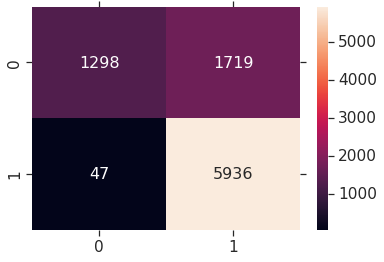

In [22]:
import matplotlib.pylab as plt
plt.show()

# <i>BOW VECTORIZATION WITH SUPPORT VECTOR MACHINE  WITH LINEAR KERNEL AND RBF KERNEL IS DONE<b>
 ********************************************************************************************************